# 311 Requests and Metro Proximity (LA)

**Goal**: Analyze whether proximity to metro rail infrastructure correlates with the volume or type of 311 requests in Los Angeles.

This notebook:
- Loads and cleans 311 request data
- Joins with Neighborhood Council and population data
- Computes distance to nearest metro stop
- Visualizes request patterns spatially and temporally

Builds on work by [@priyakalyan](https://github.com/priyakalyan) and Hack for LA contributors.
Analysis uses 2024 data from HuggingFace and LA GeoHub.

# Section 1: Setup

In [35]:
# Install necessary packages and run only once per environment

# !pip install geopandas shapely folium pyproj datasets matplotlib seaborn pandas requests

In [36]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import load_dataset
from shapely.geometry import Point

In [37]:
from pathlib import Path

# Start from the current notebook location
nb_dir = Path().resolve()

# To the project root
project_root = nb_dir.parent

DATA_RAW = project_root / "data" / "raw"
DATA_CLEANED = project_root / "data" / "cleaned"

# Section 2: Load 311 Data (2024)

In [38]:
# Load LA 311 service requests dataset from HuggingFace if available, 1,442,290 records, 34 columns

In [39]:
# Fetch data from huggingface, as of now the 2024 is the latest dataset available https://huggingface.co/datasets/311-data/2024, datasets available from 2020-2024 so far

dataset = load_dataset("311-data/2024", split="train")
df_311 = dataset.to_pandas()
print("Loaded 2024 subset of 311 data:", df_311.shape)


Loaded 2024 subset of 311 data: (1442293, 34)


# Section 3: Load Metro Data

In [6]:
# Manual step: Download most recent metro stop shapefiles from: (this has been done and the file is available under data/cleaned)
# https://geohub.lacity.org/datasets/metro-rail-lines-stops last updated June 7, 2018, 107 records

In [7]:
# Metro Rail Lines Stops Fields: from https://maps.lacity.org/lahub/rest/services/Metro_Bus_and_Rail/MapServer/1
# OBJECTID ( type: esriFieldTypeOID, alias: OBJECTID )
# MetroLine ( type: esriFieldTypeString, alias: MetroLine, length: 100 )
# Station ( type: esriFieldTypeString, alias: Station, length: 100 )
# StopNumber ( type: esriFieldTypeInteger, alias: StopNumber )
# Shape ( type: esriFieldTypeGeometry, alias: Shape )
# TOOLTIP ( type: esriFieldTypeString, alias: TOOLTIP, length: 249 )
# NLA_URL ( type: esriFieldTypeString, alias: NLA_URL, length: 8000 )

In [8]:
metro_stops = gpd.read_file(DATA_CLEANED / 'Metro_Rail_Lines_Stops/Metro_Rail_Lines_Stops.shp')
# metro_stops = gpd.read_file('data/raw/Metro_Rail_Lines_Stops/Metro_Rail_Lines_Stops.shp')

# Section 4: Load Neighborhood Councils and Population Data

In [9]:
# Updated NC shapefile: https://geohub.lacity.org/datasets/neighborhood-councils/
# last updated Oct 14, 2020
# 99 records

# Updated NC boundaries: https://geohub.lacity.org/datasets/lahub::neighborhood-council-boundaries-2018/about
# last updated Jan 19, 2023
# 99 records

# Instead of going the ACS Census tract or zip code route, Priya has already tried the Census tract route here https://github.com/priyakalyan/Updated_NC_pop/blob/main/NC_pop_recent_no_filter.ipynb and found the join on census tract and NC boundary and then reattribution for split NCs creates an inflated population number
# the NC website has shared a PDF report for each NC and stored it here https://neighborhoodempowerment.lacity.gov/data/ -> https://drive.google.com/drive/folders/1uupIXEGEC8UlFOCQiyIPH9q7JmETn_Cx
# The specific file we are interested in is https://drive.google.com/file/d/1lM0HYvY3ZhQnbDd0m9uwAtFtstQOL9Zx/view?usp=drive_link
# I've added it to data/raw will extract the necessary information and add it to data/cleaned
# This data is sourced from ACS demographic data - 2018, 5 year estimate and updated end of Jan 2020.



In [10]:
import pdfplumber
import pandas as pd
import re

pdf_path = DATA_CLEANED / '99 NCs Demographic Data Sheet.pdf'

nc_blocks = []
with pdfplumber.open(pdf_path) as pdf:
    for page in pdf.pages:
        text = page.extract_text()
        if text:
            nc_blocks.append(text.strip())

records = []

for block in nc_blocks:
    lines = block.split("\n")

    try:
        nc_name = lines[0].strip()                       # Line 1: NC name
        total_population = int(lines[2].replace(",", ""))  # Line 3: Total Population

        # Median income via regex
        income_match = re.search(r"Median Household Income\s*\$\s*([^\n]+)", block)
        if income_match:

            digits_only = re.sub(r"[^\d]", "", income_match.group(1))
            median_income = int(digits_only)
        else:
            median_income = None

        records.append({
            "NC_Name": nc_name,
            "Population": total_population,
            "Median_Income": median_income
        })

    except Exception as e:
        print(f"Error parsing block for NC: {lines[0] if lines else 'UNKNOWN'} | {e}")

# Convert to DataFrame and inspect
df = pd.DataFrame(records)
df.head()


,NC_Name,Population,Median_Income
0,Arleta,36823,73506
1,Arroyo Seco,19861,68962
2,Atwater Village,14694,68734
3,Bel Air-Beverly Crest,27734,200001
4,Boyle Heights,87002,37391


In [11]:
# use nc_blocks[] to manually verify the data and also pdf can be accessed visa the link above to cross-check the data as needed
df["NC_Name"] = df["NC_Name"].replace({
    "Historic Cultural": "Arts District Little Tokyo"
}) # changing this to match the NC shape file and the latest name maintained by the NC https://www.hcnc-adlt.org/hoodinfo
df


,NC_Name,Population,Median_Income
0,Arleta,36823,73506
1,Arroyo Seco,19861,68962
2,Atwater Village,14694,68734
3,Bel Air-Beverly Crest,27734,200001
4,Boyle Heights,87002,37391
...,...,...,...
94,Wilmington,55688,47521
95,Wilshire Center Koreatown,106190,38149
96,Winnetka,48459,70474
97,Woodland Hills-Warner Center,76422,96692


In [12]:
df.to_csv(DATA_CLEANED / 'nc_demographics_2020.csv', index=False)
print("\nSaved cleaned demographic table with", len(df), "rows.")


Saved cleaned demographic table with 99 rows.


In [13]:
nc_geo = gpd.read_file(DATA_CLEANED / 'Neighborhood_Council_Boundaries_(2018)/Neighborhood_Council_Boundaries_(2018).shp')

In [14]:
nc_geo["NC_Name"] = nc_geo["Name"]
nc_geo_merged = nc_geo.merge(df, on="NC_Name", how="left")

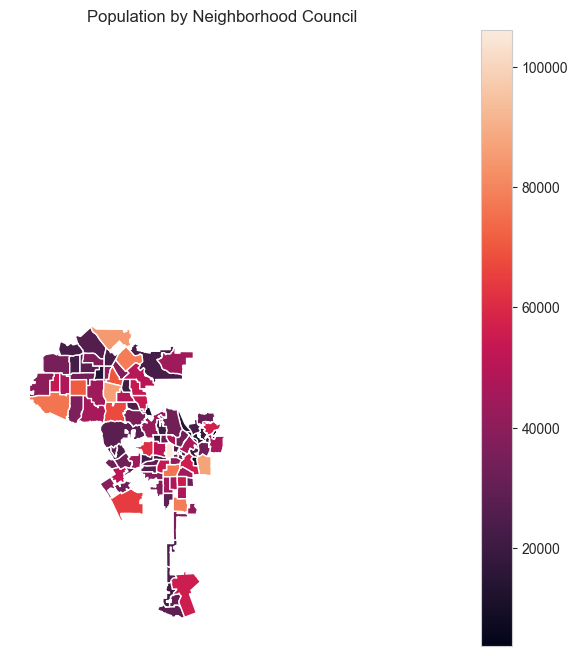

In [15]:
nc_geo_merged.plot(column="Population", legend=True, figsize=(12, 8))
plt.title("Population by Neighborhood Council")
plt.axis("off")
plt.show()

In [16]:
total_pop = nc_geo_merged["Population"].sum()
print(f"Total LA NC population: {total_pop:,}")

# Total LA NC population: 3,904,696
# This aligns with https://data.census.gov/profile/Los_Angeles_city,_California?g=160XX00US0644000
# where reported population of LA city in 2020 Decennial Census is 3,898,747
# we are good to proceed with this data

Total LA NC population: 3,904,696


# Section 5: Calculate Population Density

In [17]:
# WGS84 (EPSG:4326) uses degrees, not meters, bad for area. Reproject to something like EPSG:2229 (LA-specific) or EPSG:3857 (meters).

nc_proj = nc_geo_merged.to_crs(epsg=3857)

In [18]:
# Area in square meters
nc_proj["Area_m2"] = nc_proj.geometry.area

# Convert to square miles (1 mi² = 2,589,988.11 m²)
nc_proj["Area_mi2"] = nc_proj["Area_m2"] / 2_589_988.11

# Population Density per mi²
nc_proj["Pop_Density_per_mi2"] = nc_proj["Population"] / nc_proj["Area_mi2"]


nc_proj[["NC_Name", "Population", "Area_mi2", "Pop_Density_per_mi2"]].head()


,NC_Name,Population,Area_mi2,Pop_Density_per_mi2
0,Arleta,36823,4.805567,7662.571511
1,Arroyo Seco,19861,4.487741,4425.611620
2,Atwater Village,14694,12.837963,1144.574147
3,Bel Air-Beverly Crest,27734,24.835302,1116.716843
4,Boyle Heights,87002,8.371049,10393.202099


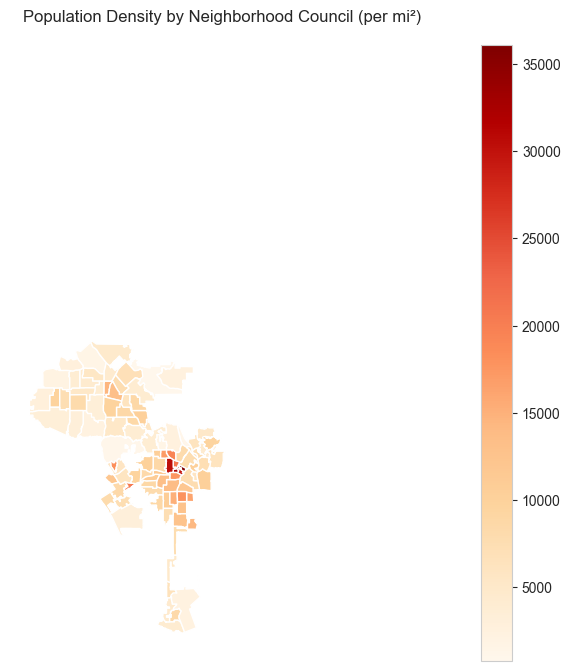

In [19]:
nc_proj.plot(column="Pop_Density_per_mi2", legend=True, figsize=(12, 8), cmap="OrRd")
plt.title("Population Density by Neighborhood Council (per mi²)")
plt.axis("off")
plt.show()


# Section 6: Spatial Join Between 311 Requests and NC Data

In [20]:
from shapely.geometry import Point
import geopandas as gpd

# Drop rows without coordinates
df_311_2024 = df_311.dropna(subset=["Latitude", "Longitude"])
#1442290 to 1440902

# Create Point geometries
geometry = [Point(xy) for xy in zip(df_311_2024["Longitude"], df_311_2024["Latitude"])]
gdf_311 = gpd.GeoDataFrame(df_311_2024, geometry=geometry, crs="EPSG:4326")


In [21]:
gdf_311_proj = gdf_311.to_crs(nc_proj.crs)

# Only keep requests that physcially fall within a NC boundary
gdf_311_joined = gpd.sjoin(gdf_311_proj, nc_proj, how="inner", predicate="within")
#1440902 to 1418336

In [22]:
# Compare NCName mismatches for curiosity

mismatches = gdf_311_joined[gdf_311_joined["NCName"] != gdf_311_joined["NC_Name"]]
print("Label mismatch examples:\n", mismatches[["NCName", "NC_Name"]].dropna())

Label mismatch examples:
                             NCName                    NC_Name
2                    Mid-City West              Mid City West
5        Foothills Trails District   Foothill Trails District
23       Foothills Trails District   Foothill Trails District
45                 Rampart Village  Wilshire Center Koreatown
48                     Arroyo Seco            Lincoln Heights
...                            ...                        ...
1442282                Zapata-King                Zapata King
1442284             Westlake South             MacArthur Park
1442286                Zapata-King                Zapata King
1442288             MacArthur Park             Westlake South
1442292                      LA-32                       LA32

[121286 rows x 2 columns]


In [23]:
gdf_311_joined = gdf_311_joined.rename(columns={"NC_Name": "NC_Assigned"})


After cleaning and joining the 2024 LA 311 dataset to Neighborhood Council (NC) boundaries:

- Original 311 records: 1,442,290
- After dropping records missing latitude/longitude: 1,440,902
- After spatial join with NC boundaries: 1,418,336
  - These requests are physically located within an LA Neighborhood Council boundary.
  - ~22,566 requests were dropped for falling outside official NC boundaries (likely unincorporated areas or bad geocoding).

Label Comparison: `NCName` vs Spatially Assigned `NC_Name`
- 121,285 requests (~8.4%) had mismatches between the original `NCName` field and the spatially joined `NC_Name`.
- Decision: Use the spatially assigned `NC_Name` (renamed `NC_Assigned`) as the authoritative label going forward, since it accurately reflects geographic location.

This ensures downstream metrics like per capita request rates or spatial models are geographically consistent and trustworthy.


In [24]:
gdf_311_proj = gdf_311_joined.to_crs(nc_proj.crs)

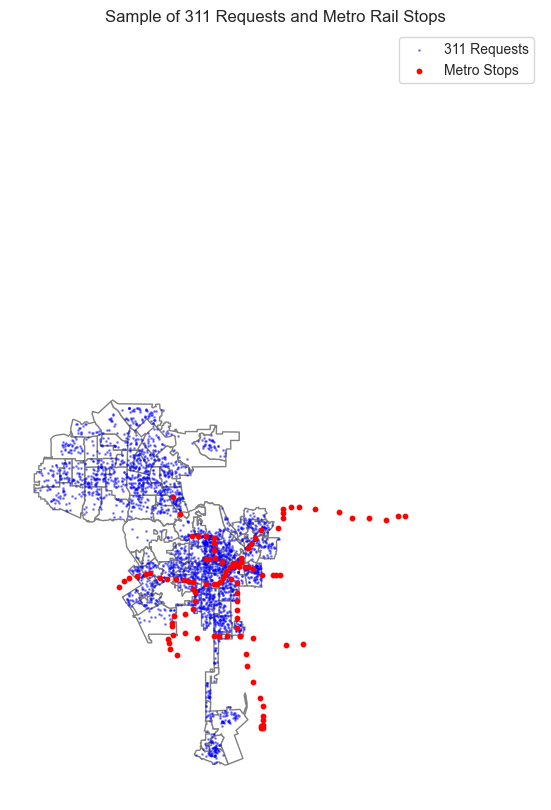

In [25]:
# --- Sampled Requests in the NC boundary overlaid with Metro stops ---
sample_311 = gdf_311_proj.sample(3000, random_state=42)

# Plot
ax = nc_proj.plot(color="white", edgecolor="gray", figsize=(12, 10))
sample_311.plot(ax=ax, markersize=1, color="blue", alpha=0.4, label="311 Requests")
metro_stops.plot(ax=ax, color="red", markersize=10, label="Metro Stops")
plt.title("Sample of 311 Requests and Metro Rail Stops")
plt.legend()
plt.axis("off")
plt.show()

/var/folders/j2/flpzfpnd6vb9fc48rxpk30900000gn/T/ipykernel_5162/1943965570.py:3: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  nc_choropleth = nc_proj.merge(nc_counts, left_on="NC_Name", right_on="NC_Assigned", how="left").fillna(0)


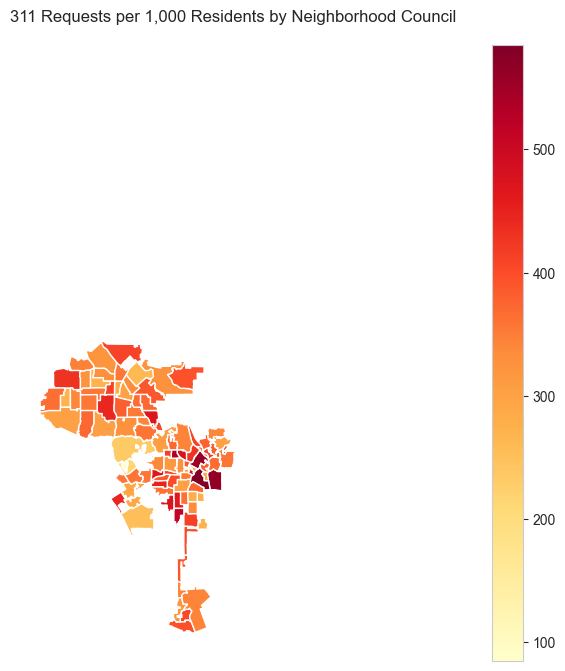

In [26]:
# --- Requests per 1000 Residents by Neighborhood Council (Choropleth) ---
nc_counts = gdf_311_joined.groupby("NC_Assigned").size().reset_index(name="Request_Count")
nc_choropleth = nc_proj.merge(nc_counts, left_on="NC_Name", right_on="NC_Assigned", how="left").fillna(0)
nc_choropleth["Requests_per_1000"] = nc_choropleth["Request_Count"] / nc_choropleth["Population"] * 1000


nc_choropleth.plot(column="Requests_per_1000", cmap="YlOrRd", legend=True, figsize=(12, 8))
plt.title("311 Requests per 1,000 Residents by Neighborhood Council")
plt.axis("off")
plt.show()


/var/folders/j2/flpzfpnd6vb9fc48rxpk30900000gn/T/ipykernel_5162/3465819194.py:3: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  nc_viz = nc_proj.merge(req_counts, left_on="NC_Name", right_on="NC_Assigned", how="left").fillna(0)


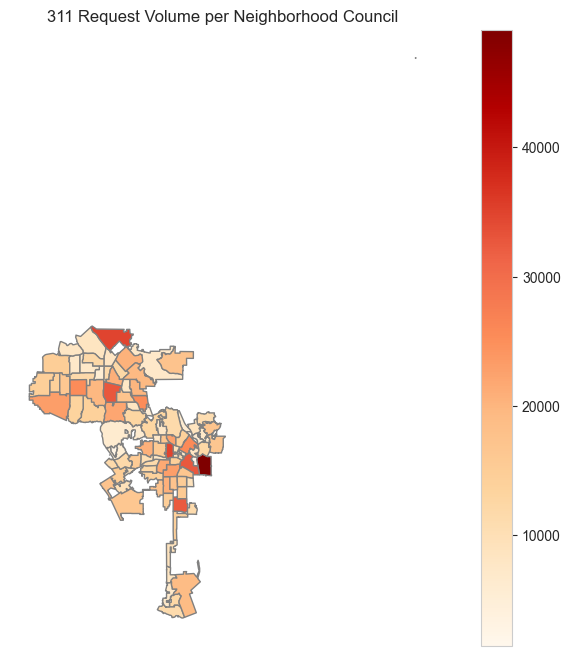

In [27]:
# --- Requests per Neighborhood Council (Raw Count Choropleth) ---
req_counts = gdf_311_proj.groupby("NC_Assigned").size().reset_index(name="Request_Count")
nc_viz = nc_proj.merge(req_counts, left_on="NC_Name", right_on="NC_Assigned", how="left").fillna(0)

nc_viz.plot(column="Request_Count", cmap="OrRd", legend=True, figsize=(12, 8), edgecolor="gray")
plt.title("311 Request Volume per Neighborhood Council")
plt.axis("off")
plt.show()

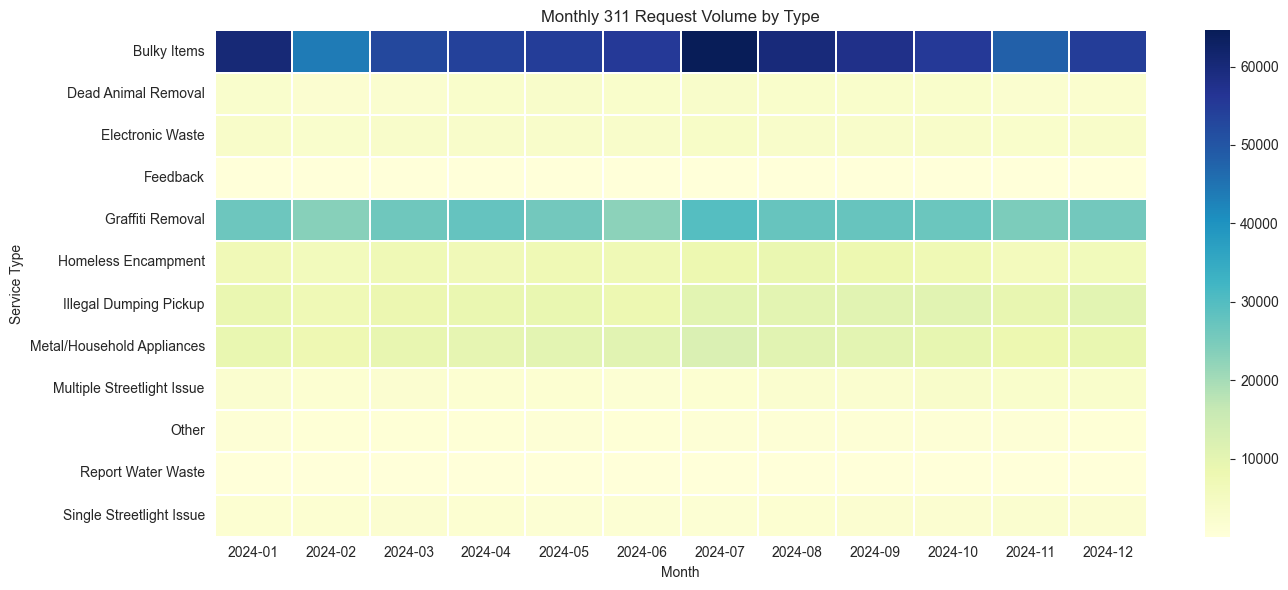

In [28]:
# --- Temporal Heatmap (Monthly) ---
gdf_311_proj['created_month'] = gdf_311_proj['CreatedDate'].dt.to_period("M")
temporal_counts = gdf_311_proj.groupby(['created_month', 'RequestType']).size().unstack(fill_value=0)

plt.figure(figsize=(14, 6))
sns.heatmap(temporal_counts.T, cmap="YlGnBu", linewidths=0.1)
plt.title("Monthly 311 Request Volume by Type")
plt.xlabel("Month")
plt.ylabel("Service Type")
plt.tight_layout()
plt.show()

# Section 7: Join 311 Requests To Metro Stops

In [29]:
metro_proj = metro_stops.to_crs(nc_proj.crs)

(107, 7)


<Axes: >

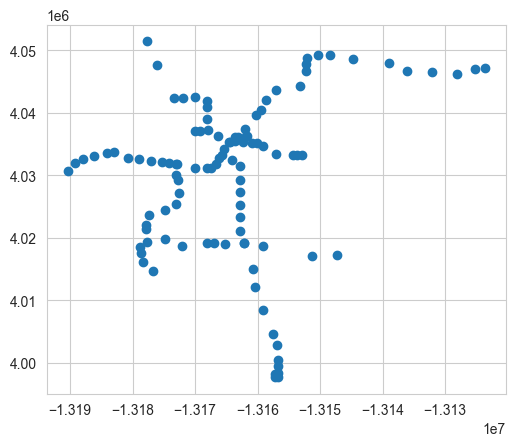

In [30]:
print(metro_stops.shape)
metro_stops.plot()

In [31]:
from shapely.ops import nearest_points

# Create a unary union of metro geometries for fast lookup
metro_union = metro_proj.union_all()

# Compute distance in meters from each request to nearest metro stop
gdf_311_proj["DistToMetro_m"] = gdf_311_proj.geometry.apply(
    lambda geom: geom.distance(nearest_points(geom, metro_union)[1])
)

# Convert distance to feet (1 meter ≈ 3.28084 feet)
gdf_311_proj["DistToMetro_ft"] = gdf_311_proj["DistToMetro_m"] * 3.28084

# Flag requests within walkable buffer zones
gdf_311_proj["Within_500ft"] = gdf_311_proj["DistToMetro_ft"] <= 500
gdf_311_proj["Within_1000ft"] = gdf_311_proj["DistToMetro_ft"] <= 1000
gdf_311_proj["Within_1320ft"] = gdf_311_proj["DistToMetro_ft"] <= 1320   # ~0.25 mile
gdf_311_proj["Within_2640ft"] = gdf_311_proj["DistToMetro_ft"] <= 2640   # ~0.5 mile

# Summary stats
print("Distance Summary (feet):")
print(gdf_311_proj["DistToMetro_ft"].describe())

print("\nShare of requests within 0.25 mile of metro (1320 ft):")
print(f"{gdf_311_proj['Within_1320ft'].mean():.2%}")

print("\nShare of requests within 0.5 mile of metro (2640 ft):")
print(f"{gdf_311_proj['Within_2640ft'].mean():.2%}")


Distance Summary (feet):
count    1.418339e+06
mean     2.295048e+04
std      2.509018e+04
min      1.363879e+01
25%      4.265078e+03
50%      1.060852e+04
75%      3.810670e+04
max      1.054428e+05
Name: DistToMetro_ft, dtype: float64

Share of requests within 0.25 mile of metro (1320 ft):
3.76%

Share of requests within 0.5 mile of metro (2640 ft):
12.73%


Text(0.5, 0, 'Feet')

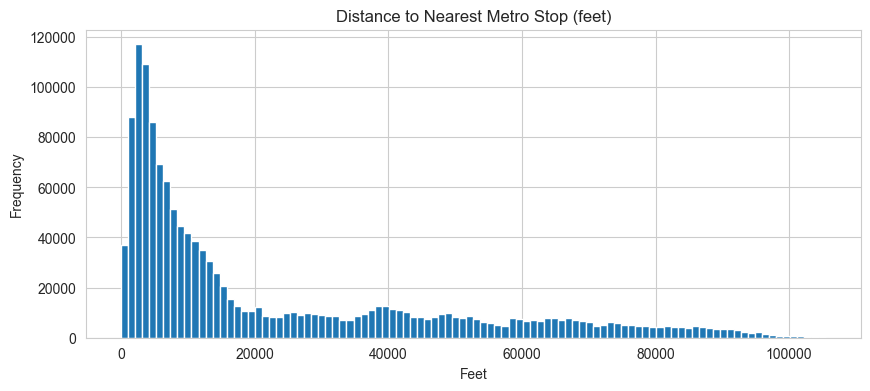

In [32]:
gdf_311_proj["DistToMetro_ft"].plot.hist(bins=100, figsize=(10,4))
plt.title("Distance to Nearest Metro Stop (feet)")
plt.xlabel("Feet")


In [33]:
gdf_311_proj["Within_2640ft"].value_counts()

Within_2640ft
False    1237806
True      180533
Name: count, dtype: int64

# Section 8: 311 Request Rates by Metro Proximity

## Core task: Build causal analysis foundation

### Step 1: Define distance bands (quantitative "treatment")

In [34]:
gdf_311_proj["MetroProximity"] = pd.cut(
    gdf_311_proj["DistToMetro_ft"],
    bins=[0, 500, 1320, 2640, float("inf")],
    labels=["<500ft", "500–1320ft", "1320–2640ft", ">2640ft"]
)

In [40]:
gdf_311_proj["MetroProximity"].value_counts()

MetroProximity
>2640ft        1237806
1320–2640ft     127268
500–1320ft       45021
<500ft            8244
Name: count, dtype: int64

In [42]:
# Sample up to 2000 points per band
gdf_sampled = (
    gdf_311_proj.groupby("MetroProximity")
    .apply(lambda x: x.sample(n=min(2000, len(x)), random_state=42))
    .reset_index(drop=True)
)


/var/folders/j2/flpzfpnd6vb9fc48rxpk30900000gn/T/ipykernel_5162/3391302120.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  gdf_311_proj.groupby("MetroProximity")
/var/folders/j2/flpzfpnd6vb9fc48rxpk30900000gn/T/ipykernel_5162/3391302120.py:4: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(n=min(2000, len(x)), random_state=42))


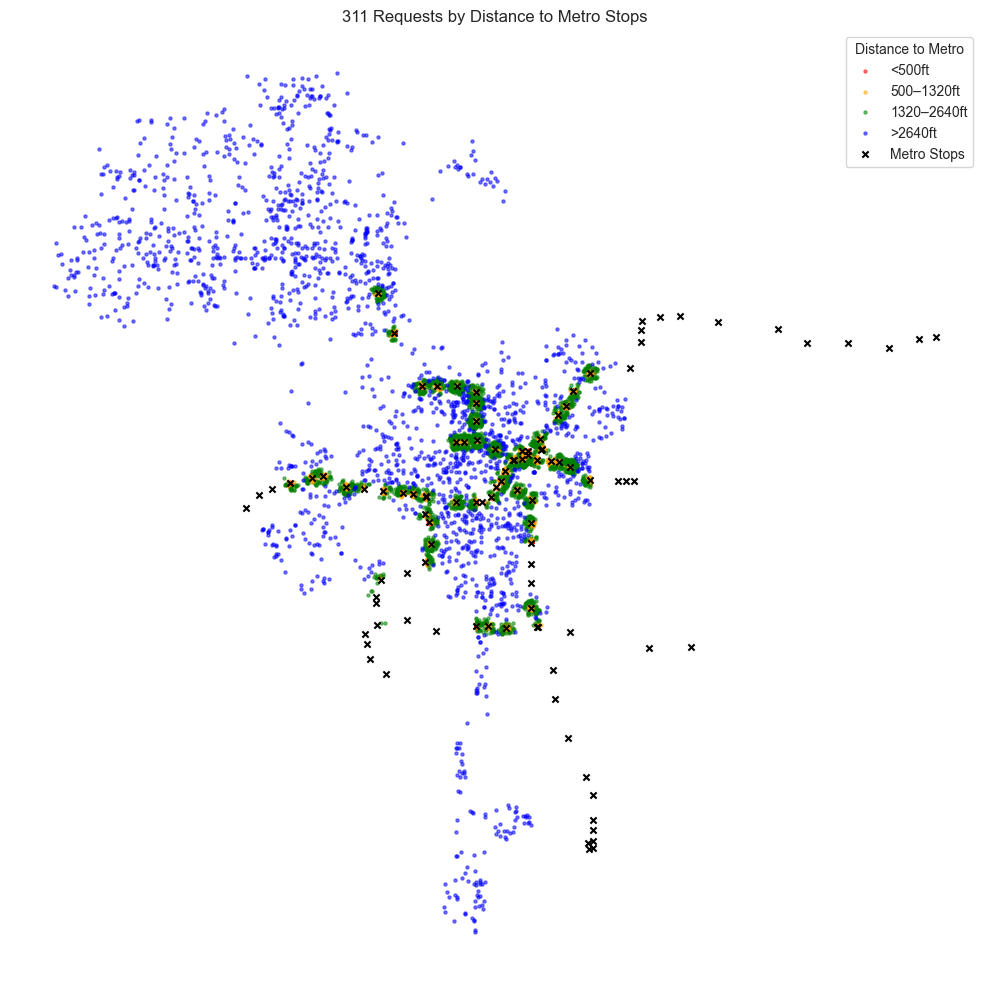

In [45]:
# Set up color map for proximity bands
proximity_colors = {
    "<500ft": "red",
    "500–1320ft": "orange",
    "1320–2640ft": "green",
    ">2640ft": "blue"
}

# Plot
fig, ax = plt.subplots(figsize=(10, 10))

# Plot 311 points with color by proximity band
for label, color in proximity_colors.items():
    gdf_sampled[gdf_sampled["MetroProximity"] == label].plot(
        ax=ax,
        markersize=5,
        color=color,
        label=label,
        alpha=0.5
    )

# Plot metro stops
metro_stops.plot(ax=ax, color='black', markersize=20, marker='x', label="Metro Stops")

# Final touches
plt.legend(title="Distance to Metro")
plt.title("311 Requests by Distance to Metro Stops")
plt.axis("off")
plt.tight_layout()
plt.show()


In [46]:
gdf_near_metro = gdf_311_proj[gdf_311_proj["MetroProximity"] != ">2640ft"]
gdf_sampled = gdf_near_metro.sample(n=5000, random_state=42)


/var/folders/j2/flpzfpnd6vb9fc48rxpk30900000gn/T/ipykernel_5162/2206123663.py:14: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  gdf_sampled[gdf_sampled["MetroProximity"] == label].plot(


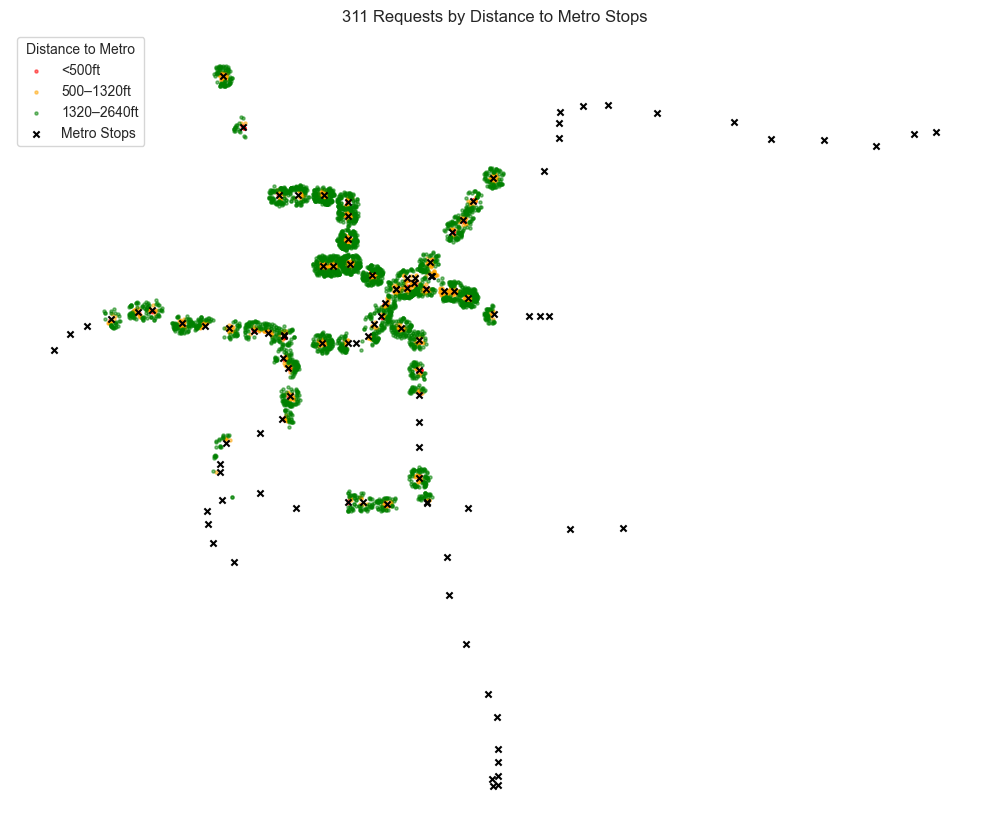

In [47]:
# Set up color map for proximity bands
proximity_colors = {
    "<500ft": "red",
    "500–1320ft": "orange",
    "1320–2640ft": "green",
    ">2640ft": "blue"
}

# Plot
fig, ax = plt.subplots(figsize=(10, 10))

# Plot 311 points with color by proximity band
for label, color in proximity_colors.items():
    gdf_sampled[gdf_sampled["MetroProximity"] == label].plot(
        ax=ax,
        markersize=5,
        color=color,
        label=label,
        alpha=0.5
    )

# Plot metro stops
metro_stops.plot(ax=ax, color='black', markersize=20, marker='x', label="Metro Stops")

# Final touches
plt.legend(title="Distance to Metro")
plt.title("311 Requests by Distance to Metro Stops")
plt.axis("off")
plt.tight_layout()
plt.show()


### Step 2: Normalize request rates per capita

In [49]:
# Group by NC and MetroProximity to get request counts

request_counts = (
    gdf_311_proj
    .groupby(["NC_Assigned", "MetroProximity"])
    .size()
    .reset_index(name="Request_Count")
)


/var/folders/j2/flpzfpnd6vb9fc48rxpk30900000gn/T/ipykernel_5162/3942375193.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(["NC_Assigned", "MetroProximity"])


In [51]:
# Get population for each NC

nc_population = nc_proj[["NC_Name", "Population"]]


In [52]:
# Add population to the request table

merged = request_counts.merge(nc_population, left_on="NC_Assigned", right_on="NC_Name", how="left")

In [53]:
# Calculate rate per 1000 residents

merged["Rate_per_1000"] = (merged["Request_Count"] / merged["Population"]) * 1000


In [54]:
merged

,NC_Assigned,MetroProximity,Request_Count,NC_Name,Population,Rate_per_1000
0,Arleta,<500ft,0,Arleta,36823,0.000000
1,Arleta,500–1320ft,0,Arleta,36823,0.000000
2,Arleta,1320–2640ft,0,Arleta,36823,0.000000
3,Arleta,>2640ft,12334,Arleta,36823,334.953697
4,Arroyo Seco,<500ft,255,Arroyo Seco,19861,12.839233
...,...,...,...,...,...,...
391,Woodland Hills-Warner Center,>2640ft,23176,Woodland Hills-Warner Center,76422,303.263458
392,Zapata King,<500ft,0,Zapata King,54784,0.000000
393,Zapata King,500–1320ft,0,Zapata King,54784,0.000000
394,Zapata King,1320–2640ft,0,Zapata King,54784,0.000000


### Step 3: Visualize request rate by proximity band

In [55]:
rate_by_band = (
    merged.groupby("MetroProximity")["Rate_per_1000"]
    .mean()
    .reset_index()
)

/var/folders/j2/flpzfpnd6vb9fc48rxpk30900000gn/T/ipykernel_5162/1388881592.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  merged.groupby("MetroProximity")["Rate_per_1000"]


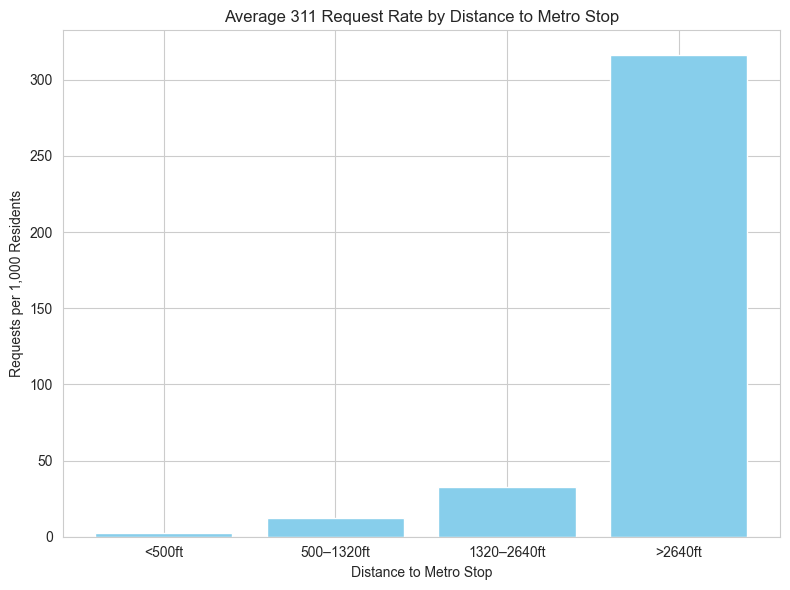

In [56]:
plt.figure(figsize=(8, 6))
plt.bar(rate_by_band["MetroProximity"], rate_by_band["Rate_per_1000"], color="skyblue")
plt.title("Average 311 Request Rate by Distance to Metro Stop")
plt.xlabel("Distance to Metro Stop")
plt.ylabel("Requests per 1,000 Residents")
plt.tight_layout()
plt.show()


### Step 4: Filter NCs that contain metro stops

In [57]:
metro_with_nc = gpd.sjoin(metro_stops, nc_proj, how="inner", predicate="within")

In [58]:
ncs_with_metro = metro_with_nc["NC_Name"].unique()

In [59]:
gdf_311_metro_ncs = gdf_311_proj[gdf_311_proj["NC_Assigned"].isin(ncs_with_metro)]
nc_proj_metro_only = nc_proj[nc_proj["NC_Name"].isin(ncs_with_metro)]


In [60]:
request_counts_metro = (
    gdf_311_metro_ncs
    .groupby(["NC_Assigned", "MetroProximity"])
    .size()
    .reset_index(name="Request_Count")
)

/var/folders/j2/flpzfpnd6vb9fc48rxpk30900000gn/T/ipykernel_5162/1055759772.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(["NC_Assigned", "MetroProximity"])


In [66]:
nc_population_metro = nc_proj_metro_only[["NC_Name", "Population"]]

In [67]:
merged_metro = request_counts.merge(nc_population_metro, left_on="NC_Assigned", right_on="NC_Name", how="left")

In [68]:
merged_metro["Rate_per_1000"] = (merged_metro["Request_Count"] / merged_metro["Population"]) * 1000

In [69]:
merged_metro

,NC_Assigned,MetroProximity,Request_Count,NC_Name,Population,Rate_per_1000
0,Arleta,<500ft,0,NaN,NaN,NaN
1,Arleta,500–1320ft,0,NaN,NaN,NaN
2,Arleta,1320–2640ft,0,NaN,NaN,NaN
3,Arleta,>2640ft,12334,NaN,NaN,NaN
4,Arroyo Seco,<500ft,255,Arroyo Seco,19861.0,12.839233
...,...,...,...,...,...,...
391,Woodland Hills-Warner Center,>2640ft,23176,NaN,NaN,NaN
392,Zapata King,<500ft,0,NaN,NaN,NaN
393,Zapata King,500–1320ft,0,NaN,NaN,NaN
394,Zapata King,1320–2640ft,0,NaN,NaN,NaN


In [70]:
rate_by_band_metro = (
    merged_metro.groupby("MetroProximity")["Rate_per_1000"]
    .mean()
    .reset_index()
)

/var/folders/j2/flpzfpnd6vb9fc48rxpk30900000gn/T/ipykernel_5162/2929144142.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  merged_metro.groupby("MetroProximity")["Rate_per_1000"]


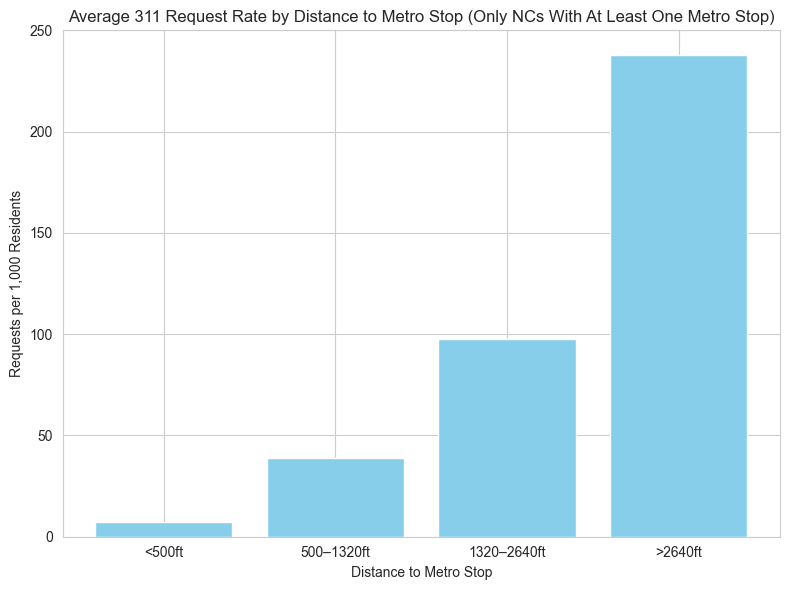

In [71]:
plt.figure(figsize=(8, 6))
plt.bar(rate_by_band_metro["MetroProximity"], rate_by_band_metro["Rate_per_1000"], color="skyblue")
plt.title("Average 311 Request Rate by Distance to Metro Stop (Only NCs With At Least One Metro Stop)")
plt.xlabel("Distance to Metro Stop")
plt.ylabel("Requests per 1,000 Residents")
plt.tight_layout()
plt.show()

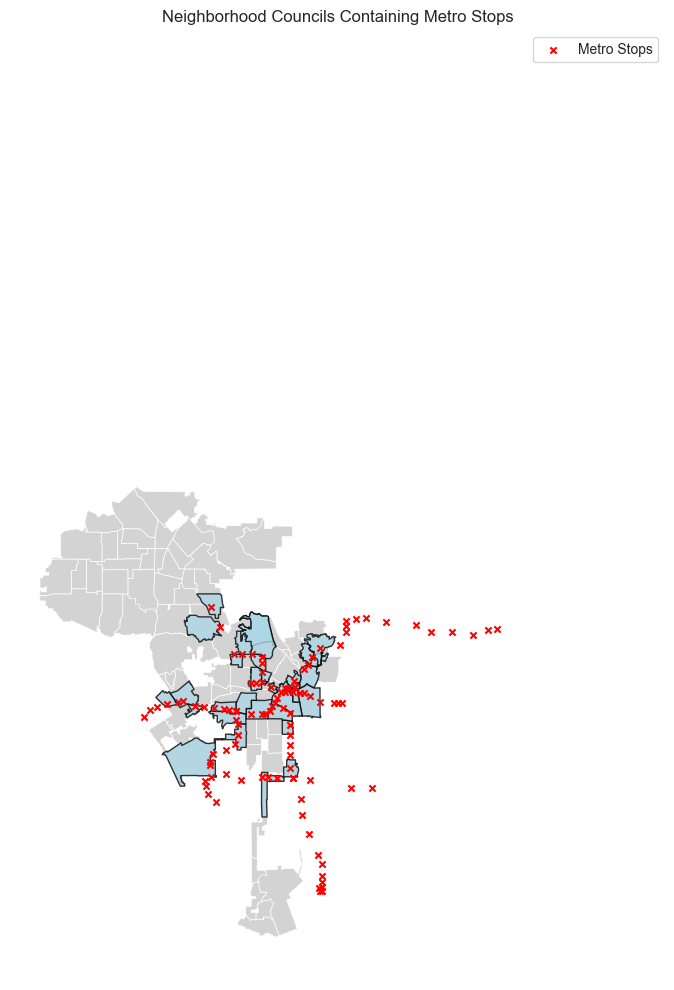

In [72]:
fig, ax = plt.subplots(figsize=(10, 10))

# Plot all NCs in light gray
nc_proj.plot(ax=ax, color="lightgray", edgecolor="white", linewidth=0.5)

# Highlight NCs that contain metro stops
nc_proj_metro_only.plot(ax=ax, color="lightblue", edgecolor="black", linewidth=1, alpha=0.8)

# Add metro stops on top
metro_stops.plot(ax=ax, color="red", markersize=20, marker='x', label="Metro Stops")

plt.title("Neighborhood Councils Containing Metro Stops")
plt.axis("off")
plt.legend()
plt.tight_layout()
plt.show()


In [74]:
full_rates = (
    merged.groupby("MetroProximity")["Rate_per_1000"]
    .mean()
    .reset_index()
    .assign(Source="All NCs")
)

metro_only_rates = (
    merged_metro.groupby("MetroProximity")["Rate_per_1000"]
    .mean()
    .reset_index()
    .assign(Source="Metro NCs Only")
)

# Combine
combined_rates = pd.concat([full_rates, metro_only_rates])


/var/folders/j2/flpzfpnd6vb9fc48rxpk30900000gn/T/ipykernel_5162/4250440172.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  merged.groupby("MetroProximity")["Rate_per_1000"]
/var/folders/j2/flpzfpnd6vb9fc48rxpk30900000gn/T/ipykernel_5162/4250440172.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  merged_metro.groupby("MetroProximity")["Rate_per_1000"]


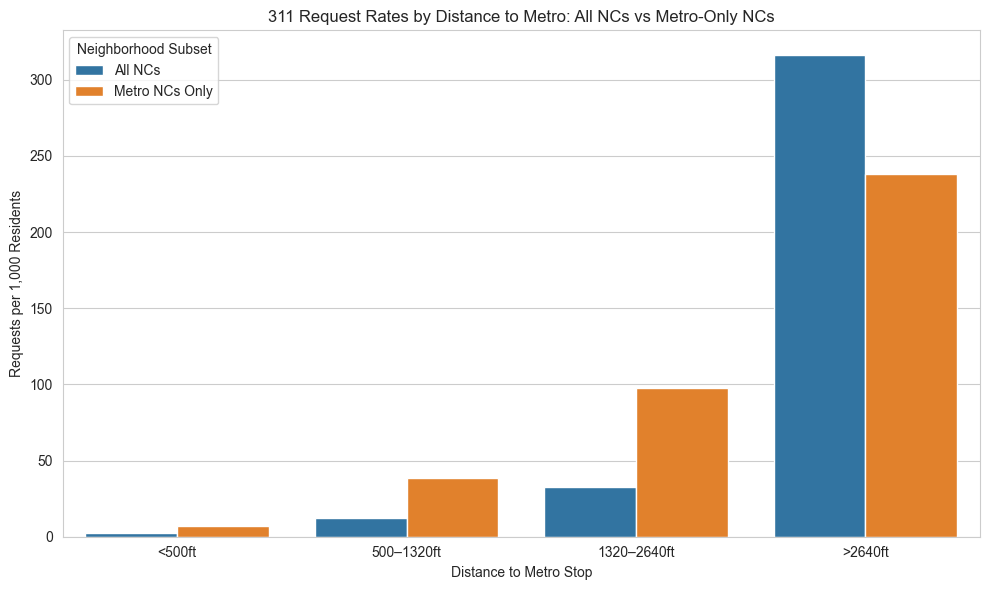

In [75]:
plt.figure(figsize=(10, 6))
sns.barplot(
    data=combined_rates,
    x="MetroProximity",
    y="Rate_per_1000",
    hue="Source"
)
plt.title("311 Request Rates by Distance to Metro: All NCs vs Metro-Only NCs")
plt.xlabel("Distance to Metro Stop")
plt.ylabel("Requests per 1,000 Residents")
plt.legend(title="Neighborhood Subset")
plt.tight_layout()
plt.show()


In [76]:
combined_rates

,MetroProximity,Rate_per_1000,Source
0,<500ft,2.163832,All NCs
1,500–1320ft,12.261549,All NCs
2,1320–2640ft,32.911922,All NCs
3,>2640ft,316.590118,All NCs
0,<500ft,7.200548,Metro NCs Only
1,500–1320ft,38.677618,Metro NCs Only
2,1320–2640ft,97.445225,Metro NCs Only
3,>2640ft,238.111786,Metro NCs Only


This approach of only keeping NCs with at least one metro stop in their border is not exactly fruitful for our analysis as there are metro stops that may fall near the edge of an NC but not technically within it. One way to deal with this would be to use the definitions as follows:
* “Treated” areas = locations <2640ft from any metro stop
* “Control” areas = locations >2640ft from all metro stops
It is interesting to observe that >2640ft for All NCs vs Metro NCs only varies so drastically but either way, still captures the bulk of the volume fo requests.

Before we decide on treated vs control design, let us look by request type to see if we might have a better causal framing.

### Step 5: Per capita requests by NC x request type x metro proximity

In [77]:
grouped = (
    gdf_311_proj
    .groupby(["NC_Assigned", "MetroProximity", "RequestType"])
    .size()
    .reset_index(name="Request_Count")
)


/var/folders/j2/flpzfpnd6vb9fc48rxpk30900000gn/T/ipykernel_5162/4126521077.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(["NC_Assigned", "MetroProximity", "RequestType"])


In [78]:
grouped = grouped.merge(
    nc_proj[["NC_Name", "Population"]],
    left_on="NC_Assigned", right_on="NC_Name",
    how="left"
)


In [79]:
grouped[grouped["Population"].isna()]


,NC_Assigned,MetroProximity,RequestType,Request_Count,NC_Name,Population


In [80]:
grouped["Rate_per_1000"] = (grouped["Request_Count"] / grouped["Population"]) * 1000

In [81]:
grouped


,NC_Assigned,MetroProximity,RequestType,Request_Count,NC_Name,Population,Rate_per_1000
0,Arleta,<500ft,Bulky Items,0,Arleta,36823,0.000000
1,Arleta,<500ft,Dead Animal Removal,0,Arleta,36823,0.000000
2,Arleta,<500ft,Electronic Waste,0,Arleta,36823,0.000000
3,Arleta,<500ft,Feedback,0,Arleta,36823,0.000000
4,Arleta,<500ft,Graffiti Removal,0,Arleta,36823,0.000000
...,...,...,...,...,...,...,...
4747,Zapata King,>2640ft,Metal/Household Appliances,988,Zapata King,54784,18.034463
4748,Zapata King,>2640ft,Multiple Streetlight Issue,294,Zapata King,54784,5.366530
4749,Zapata King,>2640ft,Other,107,Zapata King,54784,1.953125
4750,Zapata King,>2640ft,Report Water Waste,2,Zapata King,54784,0.036507


/var/folders/j2/flpzfpnd6vb9fc48rxpk30900000gn/T/ipykernel_5162/2440219561.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped.groupby(["RequestType", "MetroProximity"])["Request_Count"]


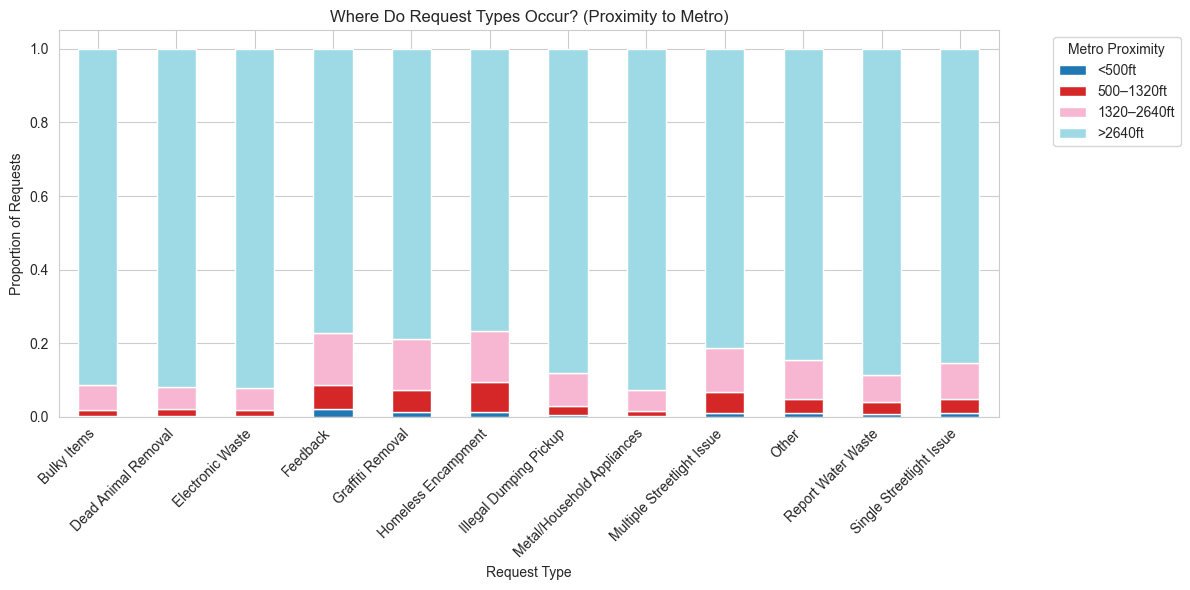

In [82]:
# Summarize request counts across all NCs
type_by_prox = (
    grouped.groupby(["RequestType", "MetroProximity"])["Request_Count"]
    .sum()
    .reset_index()
)

# Pivot: rows = Request Type, columns = Metro Proximity
pivot_df = type_by_prox.pivot(
    index="RequestType",
    columns="MetroProximity",
    values="Request_Count"
).fillna(0)

# Normalize rows to get proportions
proportion_df = pivot_df.div(pivot_df.sum(axis=1), axis=0)

# Plot
proportion_df.plot(
    kind="bar", stacked=True, figsize=(12, 6), colormap="tab20"
)
plt.title("Where Do Request Types Occur? (Proximity to Metro)")
plt.xlabel("Request Type")
plt.ylabel("Proportion of Requests")
plt.legend(title="Metro Proximity", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


/var/folders/j2/flpzfpnd6vb9fc48rxpk30900000gn/T/ipykernel_5162/2883089761.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped.groupby(["MetroProximity", "RequestType"])["Request_Count"]


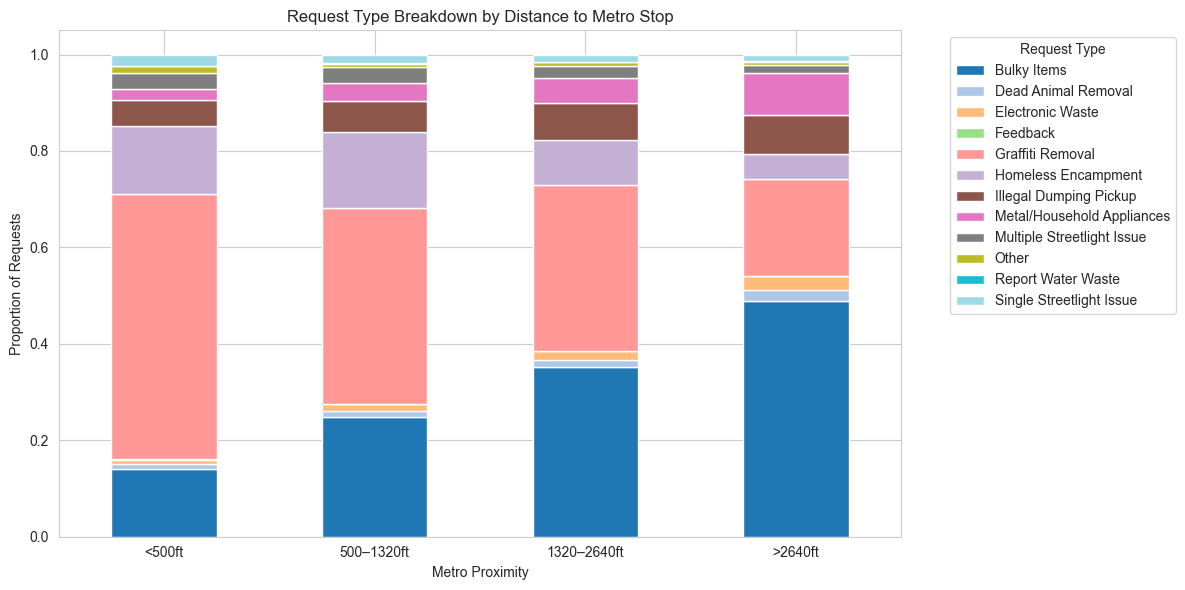

In [83]:
# Group again: total count by MetroProximity and Request Type
prox_by_type = (
    grouped.groupby(["MetroProximity", "RequestType"])["Request_Count"]
    .sum()
    .reset_index()
)

# Pivot: rows = Metro Proximity, columns = Request Type
pivot_df_flipped = prox_by_type.pivot(
    index="MetroProximity",
    columns="RequestType",
    values="Request_Count"
).fillna(0)

# Normalize rows to get proportions
proportion_df_flipped = pivot_df_flipped.div(pivot_df_flipped.sum(axis=1), axis=0)

# Plot
proportion_df_flipped.plot(
    kind="bar", stacked=True, figsize=(12, 6), colormap="tab20"
)
plt.title("Request Type Breakdown by Distance to Metro Stop")
plt.xlabel("Metro Proximity")
plt.ylabel("Proportion of Requests")
plt.legend(title="Request Type", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


/var/folders/j2/flpzfpnd6vb9fc48rxpk30900000gn/T/ipykernel_5162/338426080.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(["RequestType", "MetroProximity"])["Request_Count"]


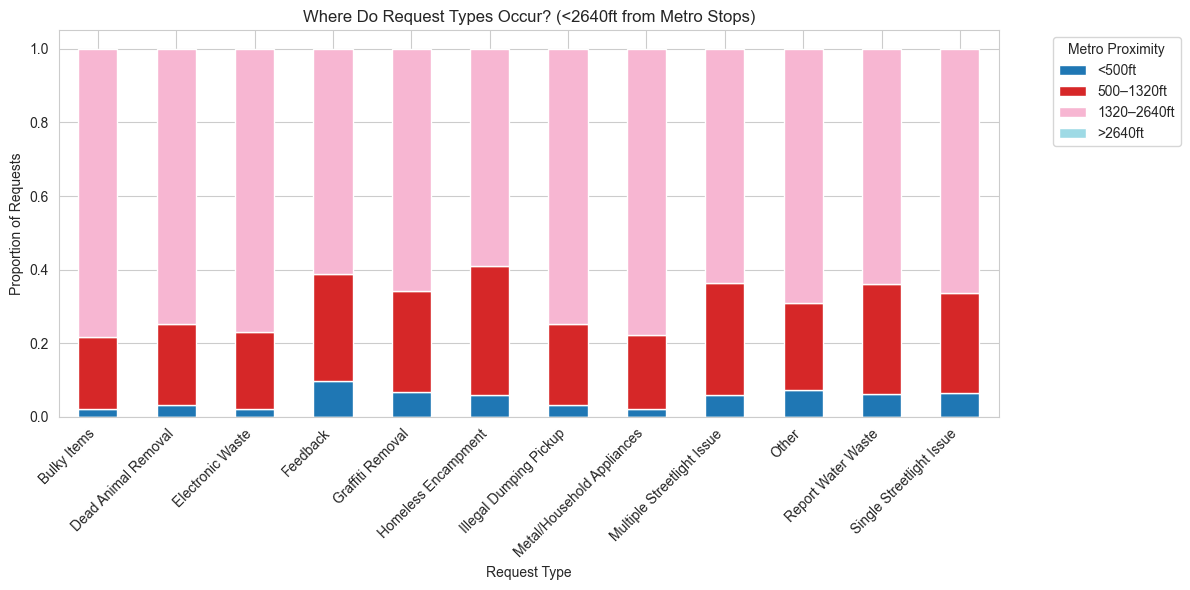

In [84]:
# Filter out >2640ft band before grouping
filtered_grouped = grouped[grouped["MetroProximity"] != ">2640ft"]

# Summarize request counts across all NCs
type_by_prox = (
    filtered_grouped
    .groupby(["RequestType", "MetroProximity"])["Request_Count"]
    .sum()
    .reset_index()
)

# Pivot: rows = Request Type, columns = Metro Proximity
pivot_df = type_by_prox.pivot(
    index="RequestType",
    columns="MetroProximity",
    values="Request_Count"
).fillna(0)

# Normalize rows to get proportions
proportion_df = pivot_df.div(pivot_df.sum(axis=1), axis=0)

# Plot
proportion_df.plot(
    kind="bar", stacked=True, figsize=(12, 6), colormap="tab20"
)
plt.title("Where Do Request Types Occur? (<2640ft from Metro Stops)")
plt.xlabel("Request Type")
plt.ylabel("Proportion of Requests")
plt.legend(title="Metro Proximity", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


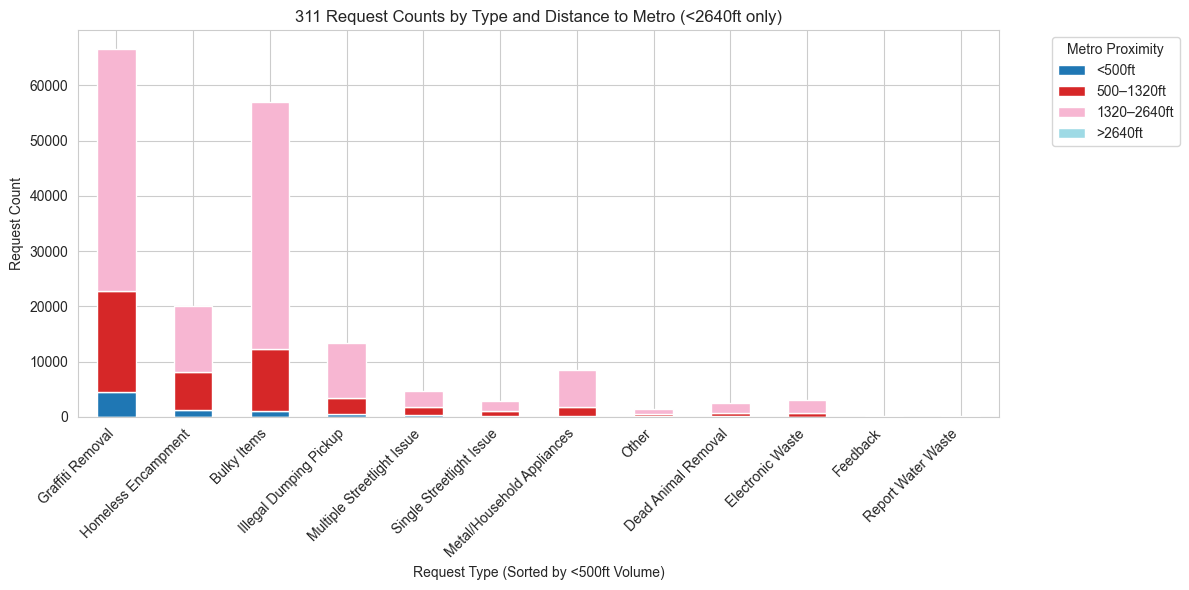

In [85]:
# Step 4: Sort by <500ft count
sorted_df = pivot_df.sort_values(by="<500ft", ascending=False)

# Step 5: Plot absolute stacked counts (not proportions)
sorted_df.plot(
    kind="bar", stacked=True, figsize=(12, 6), colormap="tab20"
)
plt.title("311 Request Counts by Type and Distance to Metro (<2640ft only)")
plt.xlabel("Request Type (Sorted by <500ft Volume)")
plt.ylabel("Request Count")
plt.legend(title="Metro Proximity", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

/var/folders/j2/flpzfpnd6vb9fc48rxpk30900000gn/T/ipykernel_5162/536132891.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(["RequestType", "MetroProximity"])["Rate_per_1000"]


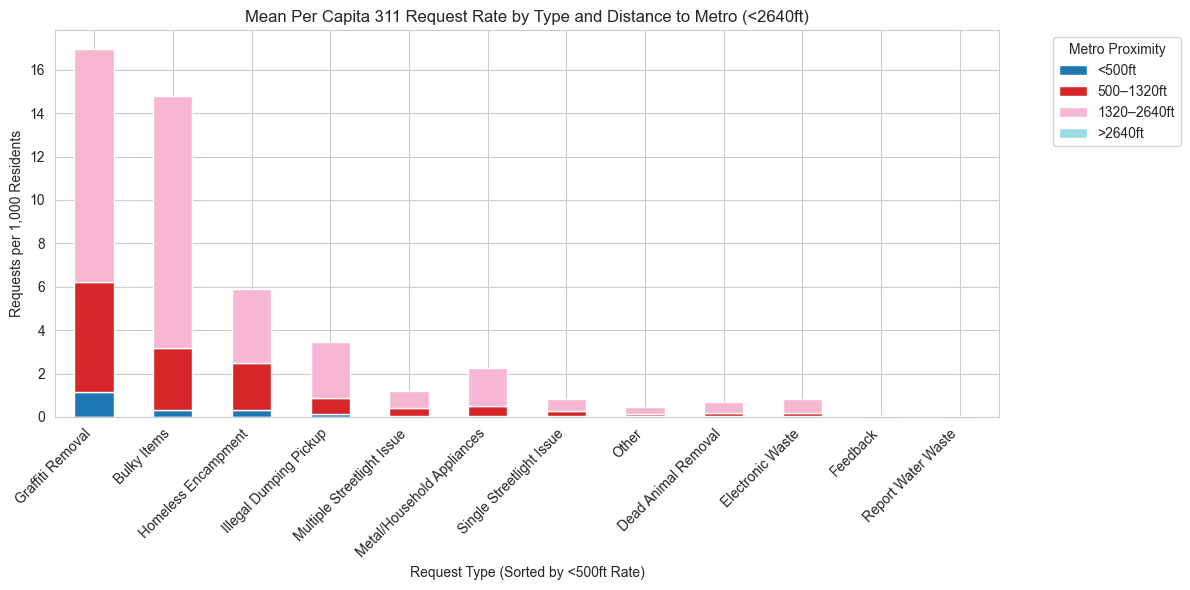

In [87]:
# Step 1: Filter out >2640ft
filtered_grouped = grouped[grouped["MetroProximity"] != ">2640ft"]

# Step 2: Average per capita rate across NCs (no population sum)
avg_per_capita = (
    filtered_grouped
    .groupby(["RequestType", "MetroProximity"])["Rate_per_1000"]
    .mean()
    .reset_index()
)

# Step 3: Pivot and sort
pivot_rate = avg_per_capita.pivot(
    index="RequestType",
    columns="MetroProximity",
    values="Rate_per_1000"
).fillna(0)

pivot_rate_sorted = pivot_rate.sort_values(by="<500ft", ascending=False)

# Step 4: Plot
pivot_rate_sorted.plot(
    kind="bar", stacked=True, figsize=(12, 6), colormap="tab20"
)
plt.title("Mean Per Capita 311 Request Rate by Type and Distance to Metro (<2640ft)")
plt.xlabel("Request Type (Sorted by <500ft Rate)")
plt.ylabel("Requests per 1,000 Residents")
plt.legend(title="Metro Proximity", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


## Summary: Metro Stop Proximity & 311 Requests (MVP Complete)

### Key Question:
Does proximity to metro stops affect the frequency and type of 311 service requests, after adjusting for population?

### This Notebook Covers:
- Computed distance bands from metro stops (`<500ft`, `500–1320ft`, `1320–2640ft`, `>2640ft`)
- Joined NC-level population data to normalize request counts
- Calculated per capita 311 request rates (per 1,000 residents)
- Visualized:
  - Absolute and per capita request volumes by proximity band
  - Distribution of request types within proximity bands
  - Where different service types are concentrated relative to metro stops

### Key Insights So Far:
- Areas close to metro stops generate **few requests in total** (due to limited geographic coverage)
- But per capita analysis reveals **meaningful variation by proximity**
- Some request types (e.g., graffiti, homeless encampment) are more concentrated **near metro stops**
- Raw volume alone is misleading, **population normalization is critical**

### Next Steps:
- Load bus stop shapefile
- Compute `DistToBus_ft` and define `BusProximity` bands
- Replicate this same analysis for bus stops:
  - Per capita normalization
  - Request type breakdown
  - Comparative charts
- Evaluate whether effects seen for metro stops are **unique** or general to all transit

### Notes:
- This notebook is complete for metro-focused MVP
- Start a new notebook for the bus stop analysis:
  **`metro_311_bus_control.ipynb`**
- Eventually combine insights into a summary notebook with causal framing

Continue with bus stop comparison to test urban proximity vs. metro-specific effects.
